In [1]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# ML libraries
import keras
# import keras.backend as K
# from tensorflow.keras.layers as K

from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

**Set Segmentation Classes and Slices Per Sample**

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 80 
VOLUME_START_AT = 60 # first slice of volume that we will include

IMG_SIZE=128

In [3]:
# Set Parent Dir
parent_dir = '/kaggle/input/brats2023-part-1'

# List files in the parent directory and check for the segmentation file
for root, dirs, files in os.walk(parent_dir):
    print(root)
    for file in files:
        print(file)


/kaggle/input/brats2023-part-1
/kaggle/input/brats2023-part-1/BraTS-GLI-00540-000
BraTS-GLI-00540-000-t2w.nii
BraTS-GLI-00540-000-seg.nii
BraTS-GLI-00540-000-t2f.nii
BraTS-GLI-00540-000-t1c.nii
BraTS-GLI-00540-000-t1n.nii
/kaggle/input/brats2023-part-1/BraTS-GLI-00725-000
BraTS-GLI-00725-000-seg.nii
BraTS-GLI-00725-000-t1n.nii
BraTS-GLI-00725-000-t1c.nii
BraTS-GLI-00725-000-t2f.nii
BraTS-GLI-00725-000-t2w.nii
/kaggle/input/brats2023-part-1/BraTS-GLI-00565-000
BraTS-GLI-00565-000-t1n.nii
BraTS-GLI-00565-000-t2f.nii
BraTS-GLI-00565-000-t1c.nii
BraTS-GLI-00565-000-seg.nii
BraTS-GLI-00565-000-t2w.nii
/kaggle/input/brats2023-part-1/BraTS-GLI-00658-000
BraTS-GLI-00658-000-seg.nii
BraTS-GLI-00658-000-t2w.nii
BraTS-GLI-00658-000-t1c.nii
BraTS-GLI-00658-000-t1n.nii
BraTS-GLI-00658-000-t2f.nii
/kaggle/input/brats2023-part-1/BraTS-GLI-00054-000
BraTS-GLI-00054-000-t1n.nii
BraTS-GLI-00054-000-t1c.nii
BraTS-GLI-00054-000-seg.nii
BraTS-GLI-00054-000-t2f.nii
BraTS-GLI-00054-000-t2w.nii
/kaggle/input/

**Loading sample into nibabel object**

In [4]:
test_image_flair=nib.load(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-t2f.nii').get_fdata()
test_image_t1=nib.load(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-t1n.nii').get_fdata()
test_image_t1ce=nib.load(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-t1c.nii').get_fdata()
test_image_t2=nib.load(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-t2w.nii').get_fdata()
test_mask=nib.load(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-seg.nii').get_fdata()

**Visualizing t2f, t1n, t1c and seg images of a sample**

Text(0.5, 1.0, 'Mask')

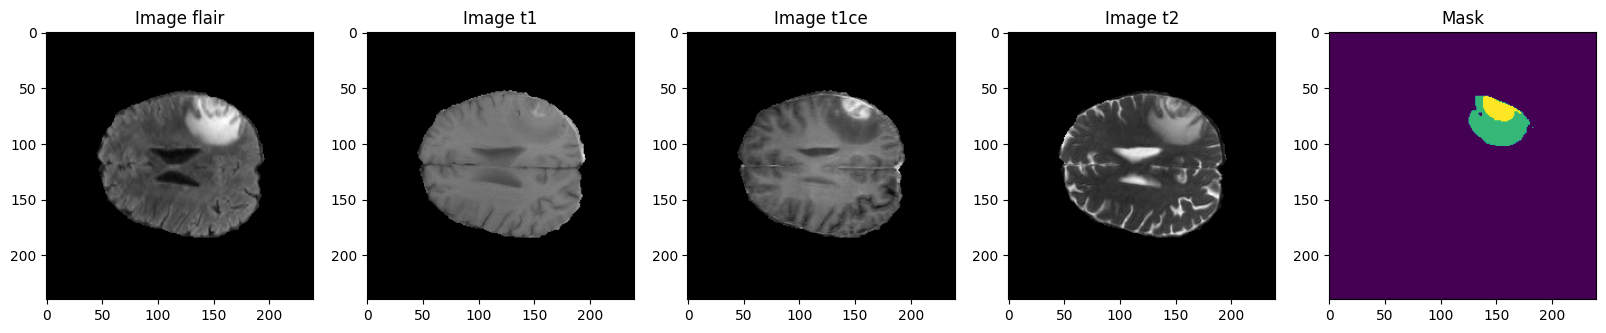

In [5]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

**Montage of flair slices**

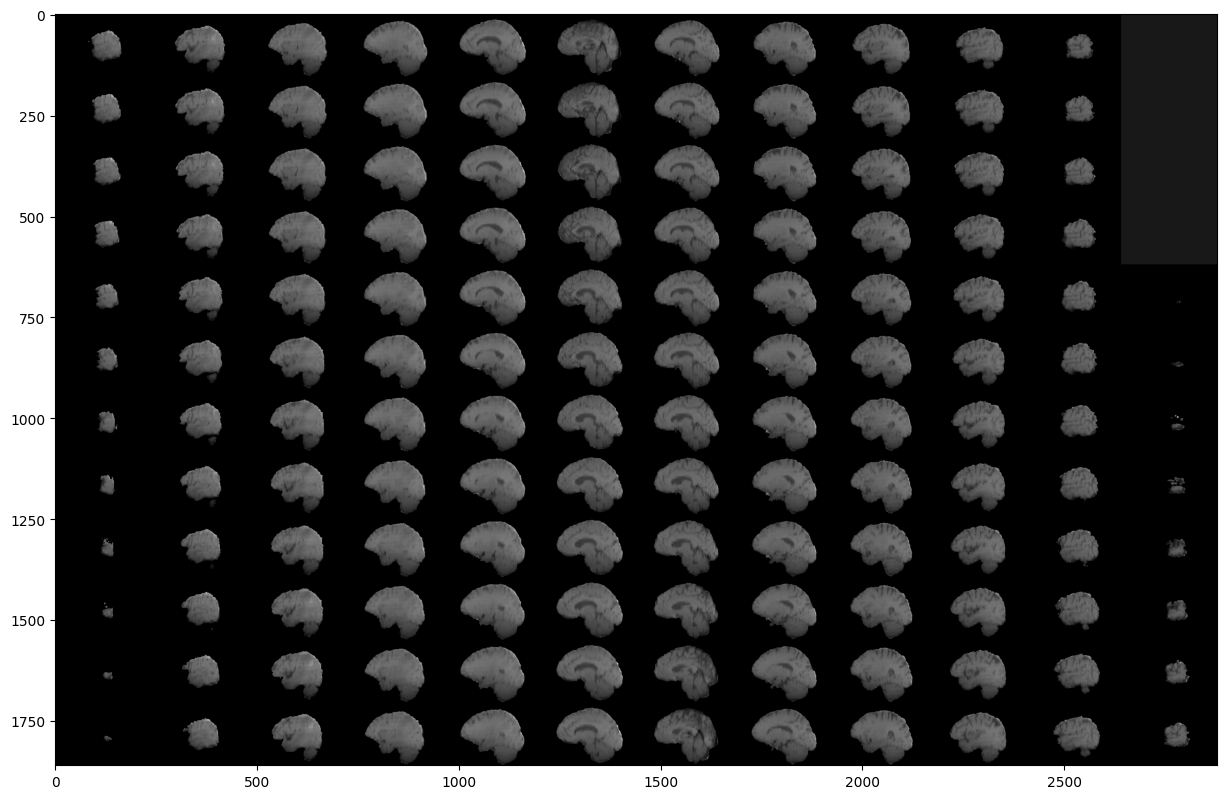

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

**Montage of Mask with 90 Degree Rotation**

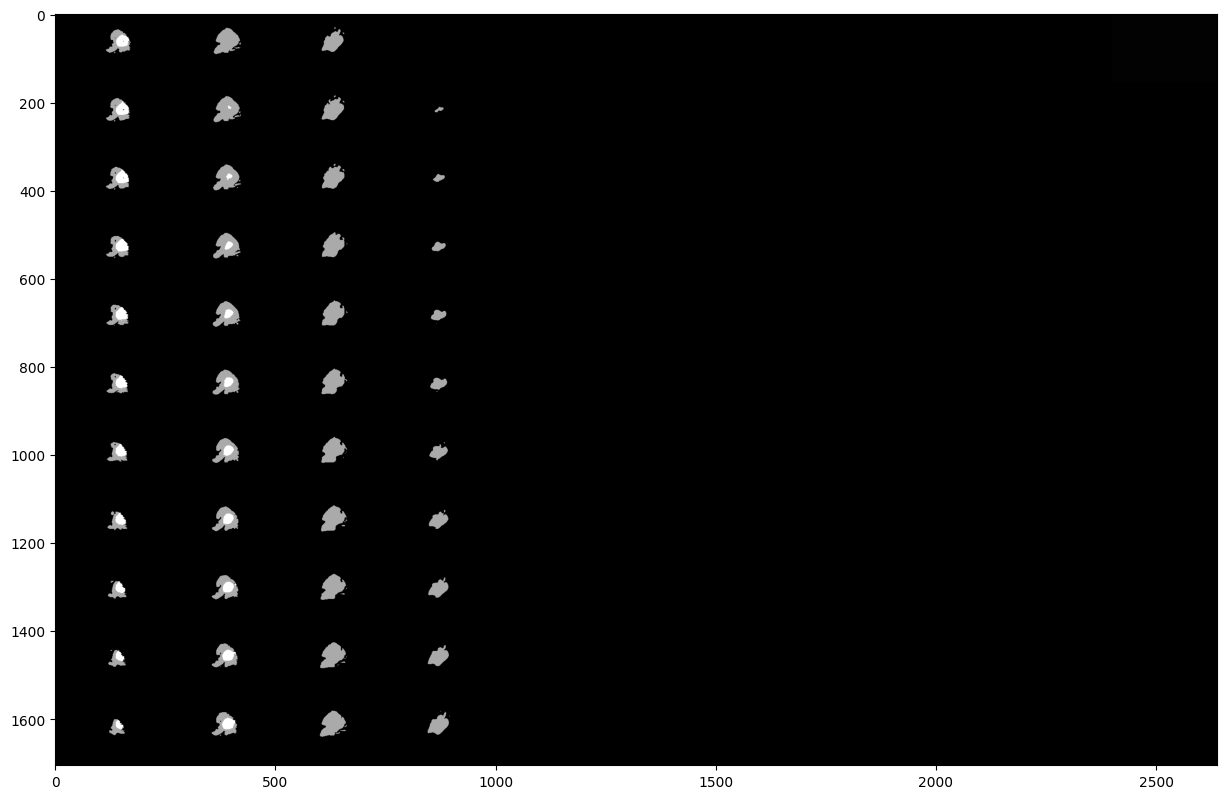

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

**Visualizing Anatomical View, Echo Planar Image View, 2D Image View and ROI View**

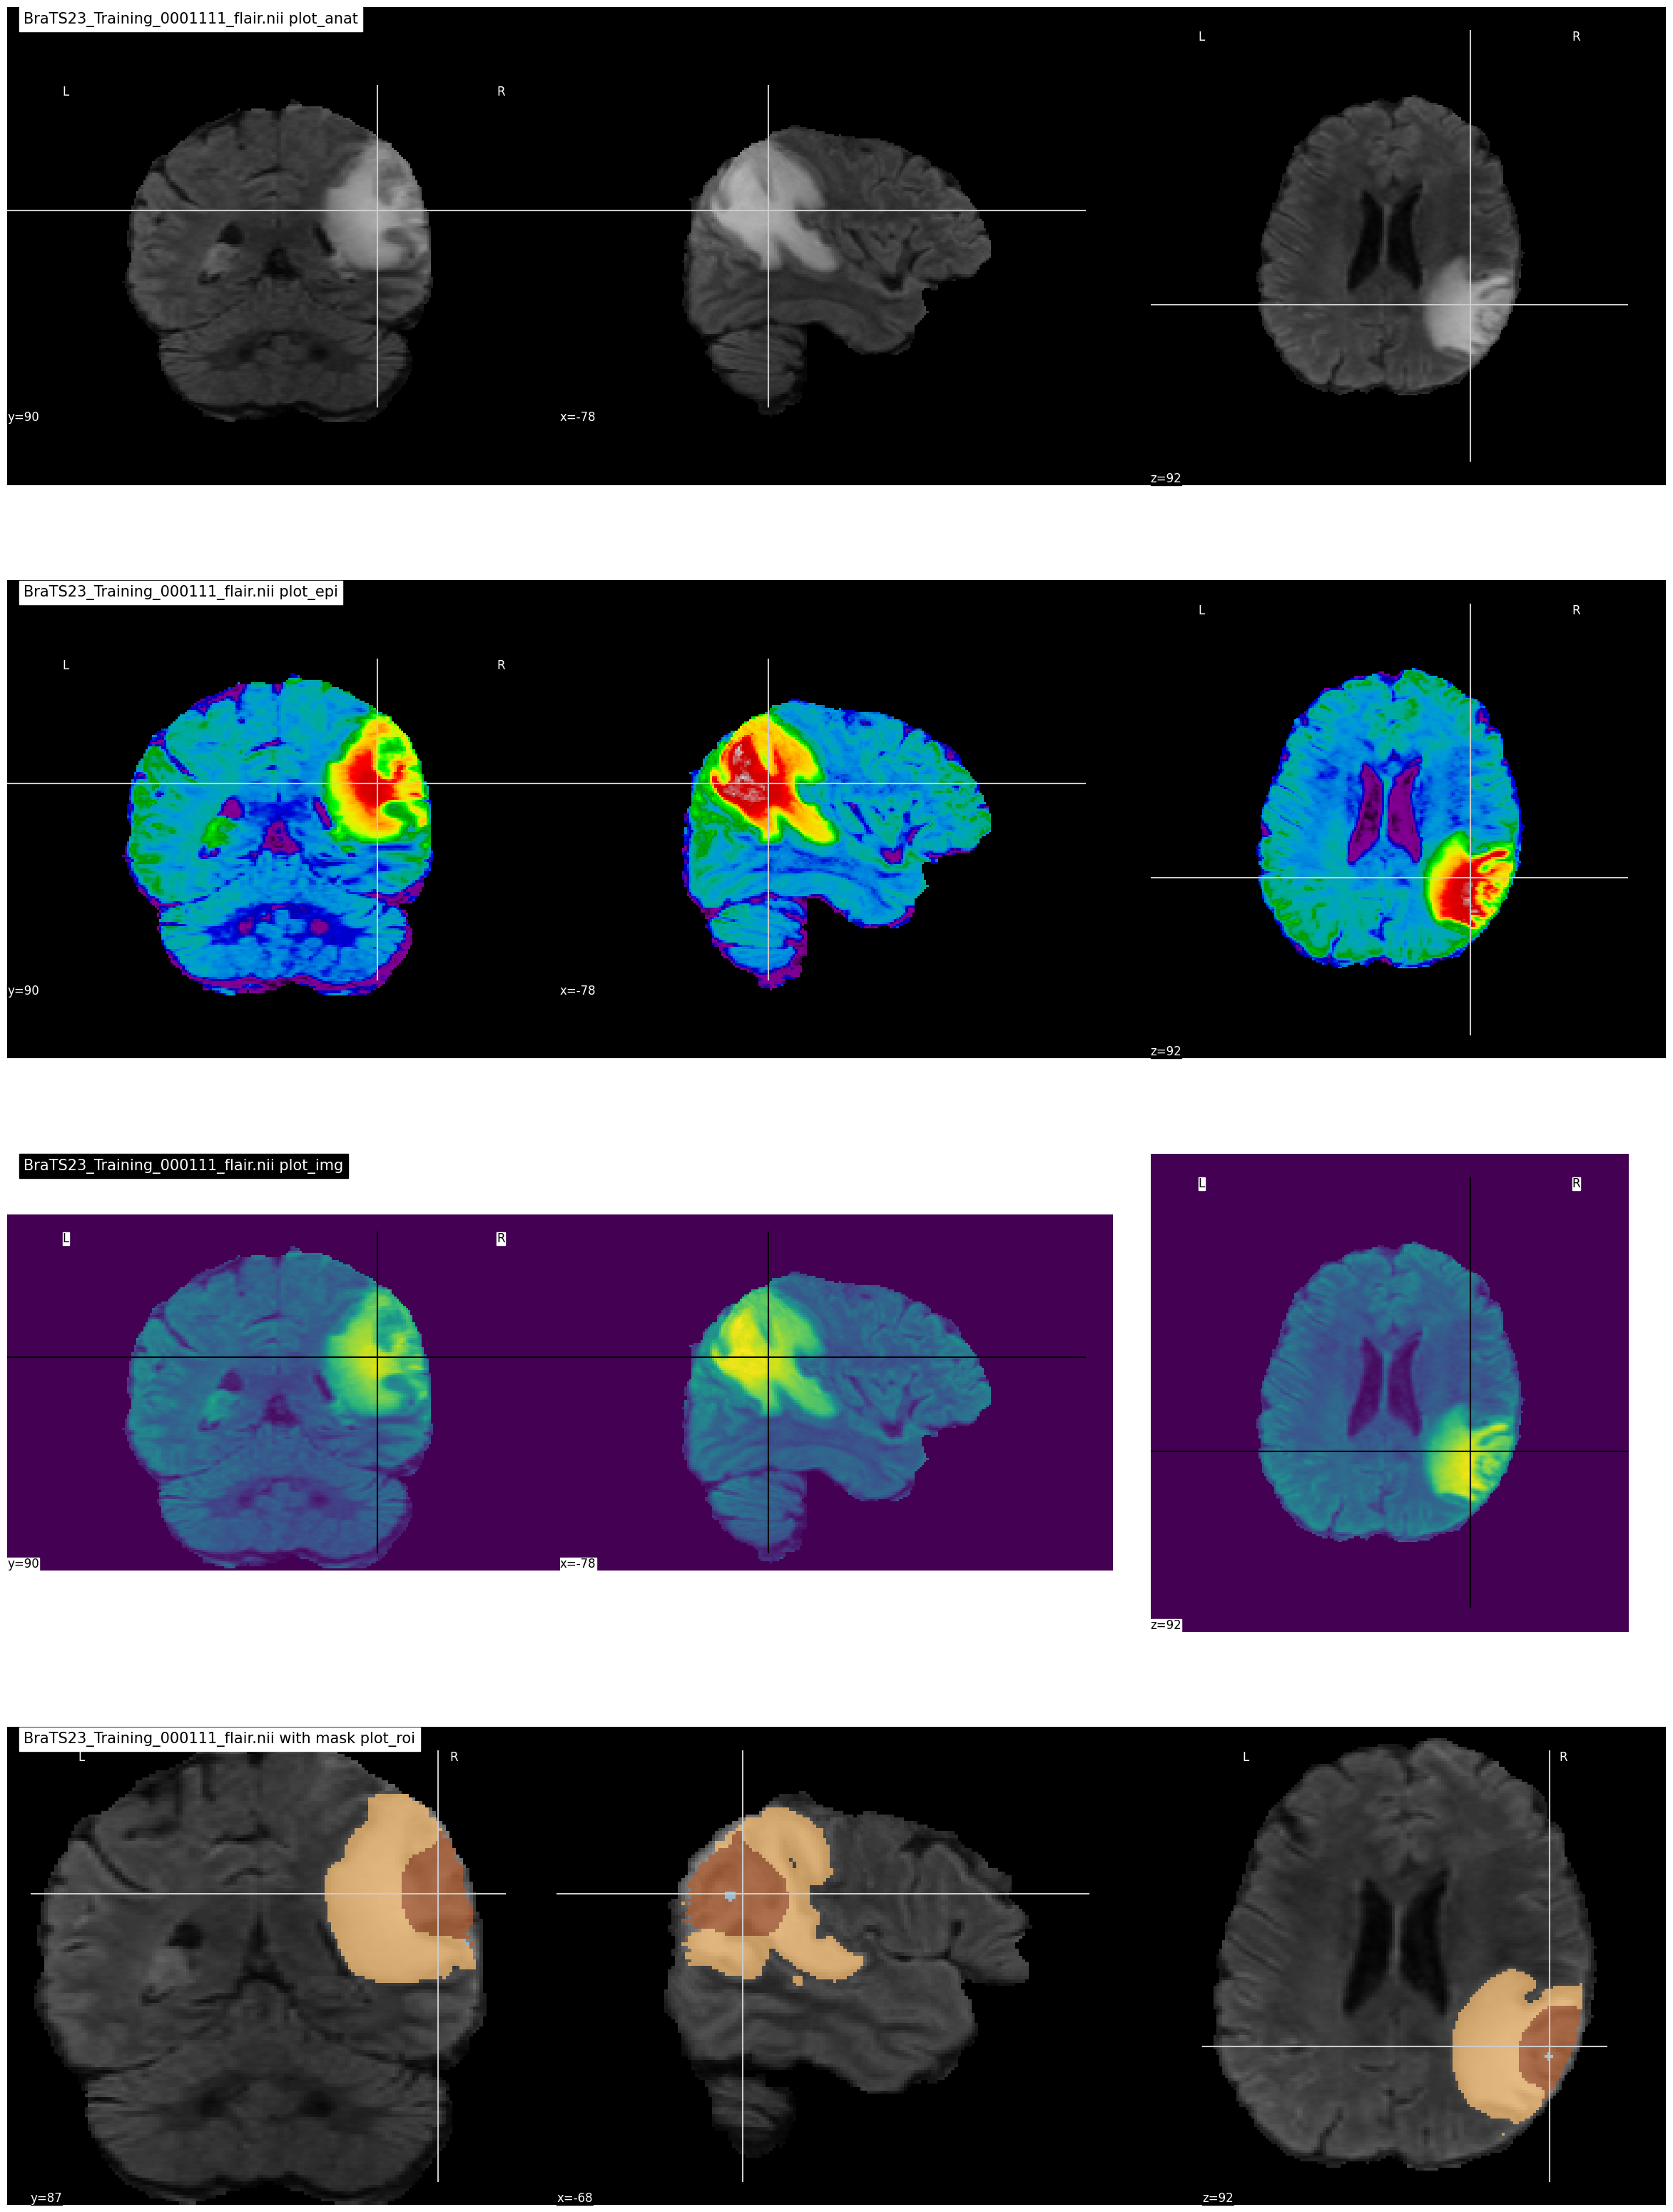

In [8]:
niimg = nl.image.load_img(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-t2f.nii')
nimask = nl.image.load_img(parent_dir + '/BraTS-GLI-00011-000/BraTS-GLI-00011-000-seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS23_Training_0001111_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS23_Training_000111_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS23_Training_000111_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS23_Training_000111_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

**Accuracy Metrics**

In [9]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

**Model Arch.**

**Train and Validation Split**

In [10]:
# # lists of directories with studies
# train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


# def pathListIntoIds(dirList):
#     x = []
#     for i in range(0,len(dirList)):
#         x.append(dirList[i][dirList[i].rfind('/')+1:])
#     return x

# train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
# train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
# train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

**Dataloader (change it as required)**

In [11]:
# class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True, **kargs):
#         'Initialization'
#         super().__init__(**kargs)
#         self.dim = dim
#         self.batch_size = batch_size
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
#         Batch_ids = [self.list_IDs[k] for k in indexes]
#         X, y = self.__data_generation(Batch_ids)
#         return X, y

#     def on_epoch_end(self):
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def load_image_data(self, case_path, img_type):
#         data_path = os.path.join(case_path, f'{img_type}.nii.gz')
#         return nib.load(data_path).get_fdata()

#     def resize_image(self, image, target_size):
#         return cv2.resize(image, target_size)

#     def zscore_normalize(self, image):
#         'Z-score normalization'
#         mean = np.mean(image)
#         std = np.std(image)
#         return (image - mean) / std if std > 0 else image

#     def preprocess_image(self, flair, ce):
#         flair_normalized = self.zscore_normalize(flair)
#         ce_normalized = self.zscore_normalize(ce)
#         return flair_normalized, ce_normalized

#     def preprocess_segmentation(self, seg):
#         'Ensure segmentation values are in the range [0, num_classes - 1]'
#         seg = seg.astype(np.uint8)
#         seg[seg == 4] = 3  # Adjust tumor labels if necessary
#         return seg

#     def generate_mask(self, seg):
#         mask = tf.one_hot(seg, 4)
#         resized_mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
#         return resized_mask

#     def __data_generation(self, Batch_ids):
#         X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
#         y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
#         Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

#         for c, i in enumerate(Batch_ids):
#             case_path = os.path.join(TRAIN_DATASET_PATH, i)
#             flair = self.load_image_data(case_path, f'{i}_flair')
#             ce = self.load_image_data(case_path, f'{i}_t1ce')
#             seg = self.load_image_data(case_path, f'{i}_seg')

#             # Preprocess segmentation
#             seg = self.preprocess_segmentation(seg)

#             for j in range(VOLUME_SLICES):
#                 flair_slice = self.resize_image(flair[:, :, j + VOLUME_START_AT], self.dim)
#                 ce_slice = self.resize_image(ce[:, :, j + VOLUME_START_AT], self.dim)
#                 flair_slice, ce_slice = self.preprocess_image(flair_slice, ce_slice)
                
#                 X[j + VOLUME_SLICES * c, :, :, 0] = flair_slice
#                 X[j + VOLUME_SLICES * c, :, :, 1] = ce_slice
#                 y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

#         Y = self.generate_mask(y)
#         return X, Y

# # Example usage
# training_generator = DataGenerator(train_ids)
# valid_generator = DataGenerator(val_ids)
# test_generator = DataGenerator(test_ids)


**Model Testing and Results (change as required)**

In [12]:
# from keras.callbacks import ModelCheckpoint, EarlyStopping

# filepath="SANet2021Brats-{epoch:02d}-{val_accuracy:.3f}.keras" 

# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# csv_logger = CSVLogger('training_2021_2D_SANet.log')

# history =  model.fit(training_generator,
#                     epochs=30,
#                     steps_per_epoch=len(train_ids),
#                     callbacks= [checkpoint, csv_logger, early_stop],
#                     validation_data = valid_generator
#                     )  